<a href="https://colab.research.google.com/github/drrao01/gpr2_v01/blob/main/AFM_423_GPR2_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO (Mark things as completed when done): 

1.   Load in data
2.   Data Preprocessing (Merge all data sets, remove days with low volume, make graphs/data viz. regarding price, moneyness, profitability, and volume trends, convert time-to-maturity to hours) 
3.   Apply Black Scholes Model
4.   Apply simple NN (with factor data and without factor data)
5.   Apply gated NN (with factor data and without factor data)
6.   Create results summary (training times, accuracy, MSE, MAPE, graph of predicted price vs actual price)





In [28]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib
import seaborn
import sklearn 
import datetime as dt

In [30]:
url = 'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_201101.txt'
#names = [QUOTE_UNIXTIME], [QUOTE_READTIME], [QUOTE_DATE], [QUOTE_TIME_HOURS], [UNDERLYING_LAST], [EXPIRE_DATE], [EXPIRE_UNIX], [DTE], [C_DELTA], [C_GAMMA], [C_VEGA], [C_THETA], [C_RHO], [C_IV], [C_VOLUME], [C_LAST], [C_SIZE], [C_BID], [C_ASK], [STRIKE], [P_BID], [P_ASK], [P_SIZE], [P_LAST], [P_DELTA], [P_GAMMA], [P_VEGA], [P_THETA], [P_RHO], [P_IV], [P_VOLUME], [STRIKE_DISTANCE], [STRIKE_DISTANCE_PCT]
df = pd.read_csv(url, sep=",")

In [31]:
print(df.shape)

(14900, 33)


In [32]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00098,0.00003,0.00559,-0.01984,-0.00044,0.533330,,221.4,0.174
1,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00164,0.00004,0.00572,-0.01861,-0.00045,0.471210,10.000000,196.4,0.154
2,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00117,0.00009,0.00667,-0.01863,-0.00025,0.411160,196.000000,171.4,0.135
3,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00392,0.00016,0.01753,-0.05175,-0.00112,0.391020,416.000000,146.4,0.115
4,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.10,-0.00714,0.00036,0.03018,-0.08182,-0.00160,0.345100,,121.4,0.095


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14900 entries, 0 to 14899
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   [QUOTE_UNIXTIME]        14900 non-null  int64  
 1    [QUOTE_READTIME]       14900 non-null  object 
 2    [QUOTE_DATE]           14900 non-null  object 
 3    [QUOTE_TIME_HOURS]     14900 non-null  float64
 4    [UNDERLYING_LAST]      14900 non-null  float64
 5    [EXPIRE_DATE]          14900 non-null  object 
 6    [EXPIRE_UNIX]          14900 non-null  int64  
 7    [DTE]                  14900 non-null  float64
 8    [C_DELTA]              14900 non-null  float64
 9    [C_GAMMA]              14900 non-null  float64
 10   [C_VEGA]               14900 non-null  float64
 11   [C_THETA]              14900 non-null  float64
 12   [C_RHO]                14900 non-null  float64
 13   [C_IV]                 14900 non-null  object 
 14   [C_VOLUME]             14900 non-null

In [34]:
years = list(range(11, 21))
months = list(range(1, 12))

for year in years: 
  for month in months: 
    #print(f'{year} - {month}:')
    if month < 10:
      url = f'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_20{year}0{month}.txt'
    else:
      url = f'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_20{year}{month}.txt'
    df_temp = pd.read_csv(url)
    print(f'{year} - {month}: {df_temp.shape}')
    df = df.append(df_temp)

print(df.shape)

11 - 1: (14900, 33)
11 - 2: (19061, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11,12,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


11 - 3: (23066, 33)
11 - 4: (19382, 33)
11 - 5: (21145, 33)
11 - 6: (21725, 33)
11 - 7: (19353, 33)
11 - 8: (22518, 33)
11 - 9: (22731, 33)
11 - 10: (21509, 33)
11 - 11: (21452, 33)
12 - 1: (20978, 33)
12 - 2: (22074, 33)
12 - 3: (26229, 33)
12 - 4: (23010, 33)
12 - 5: (25095, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


12 - 6: (26478, 33)
12 - 7: (28004, 33)
12 - 8: (32414, 33)
12 - 9: (26315, 33)
12 - 10: (32401, 33)
12 - 11: (32211, 33)
13 - 1: (29707, 33)
13 - 2: (27387, 33)
13 - 3: (28575, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18,20,21,23,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


13 - 4: (33069, 33)
13 - 5: (35163, 33)
13 - 6: (31388, 33)
13 - 7: (37311, 33)
13 - 8: (38133, 33)
13 - 9: (35261, 33)
13 - 10: (39599, 33)
13 - 11: (36706, 33)
14 - 1: (40366, 33)
14 - 2: (40989, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


14 - 3: (47380, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


14 - 4: (45407, 33)
14 - 5: (46143, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


14 - 6: (46357, 33)
14 - 7: (51560, 33)
14 - 8: (51202, 33)
14 - 9: (60510, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


14 - 10: (68658, 33)
14 - 11: (60412, 33)
15 - 1: (63865, 33)
15 - 2: (64824, 33)
15 - 3: (83935, 33)
15 - 4: (80223, 33)
15 - 5: (76337, 33)
15 - 6: (87934, 33)
15 - 7: (88135, 33)
15 - 8: (90100, 33)
15 - 9: (97117, 33)
15 - 10: (88920, 33)
15 - 11: (79053, 33)
16 - 1: (69848, 33)
16 - 2: (74328, 33)
16 - 3: (85698, 33)
16 - 4: (76118, 33)
16 - 5: (74615, 33)
16 - 6: (72743, 33)
16 - 7: (70894, 33)
16 - 8: (81812, 33)
16 - 9: (79785, 33)
16 - 10: (84803, 33)
16 - 11: (80908, 33)
17 - 1: (85461, 33)
17 - 2: (78346, 33)
17 - 3: (93903, 33)
17 - 4: (76916, 33)
17 - 5: (88272, 33)
17 - 6: (87612, 33)
17 - 7: (77861, 33)
17 - 8: (89619, 33)
17 - 9: (77390, 33)
17 - 10: (91300, 33)
17 - 11: (89585, 33)
18 - 1: (97544, 33)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


18 - 2: (98484, 33)
18 - 3: (110407, 33)
18 - 4: (113627, 33)
18 - 5: (116481, 33)
18 - 6: (111445, 33)
18 - 7: (116027, 33)
18 - 8: (128380, 33)
18 - 9: (107017, 33)
18 - 10: (136674, 33)
18 - 11: (127175, 33)
19 - 1: (128066, 33)
19 - 2: (109343, 33)
19 - 3: (110807, 33)
19 - 4: (117842, 33)
19 - 5: (116178, 33)
19 - 6: (112336, 33)
19 - 7: (128786, 33)
19 - 8: (126689, 33)
19 - 9: (106921, 33)
19 - 10: (132203, 33)
19 - 11: (125946, 33)
20 - 1: (141027, 33)
20 - 2: (132836, 33)
20 - 3: (182489, 33)
20 - 4: (149674, 33)
20 - 5: (122921, 33)
20 - 6: (140718, 33)
20 - 7: (144085, 33)
20 - 8: (138634, 33)
20 - 9: (154709, 33)
20 - 10: (150346, 33)
20 - 11: (129871, 33)
(8322182, 33)


In [37]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00098,0.00003,0.00559,-0.01984,-0.00044,0.533330,,221.4,0.174
1,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00164,0.00004,0.00572,-0.01861,-0.00045,0.471210,10.000000,196.4,0.154
2,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00117,0.00009,0.00667,-0.01863,-0.00025,0.411160,196.000000,171.4,0.135
3,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.05,-0.00392,0.00016,0.01753,-0.05175,-0.00112,0.391020,416.000000,146.4,0.115
4,1294088400,2011-01-03 16:00,2011-01-03,16.0,1271.36,2011-01-07,1294434000,4.0,1.0,0.0,...,0.1,-0.00714,0.00036,0.03018,-0.08182,-0.0016,0.345100,,121.4,0.095


In [41]:
df.columns

Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')

87


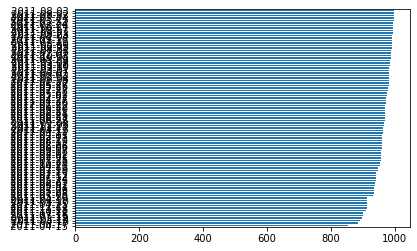

In [56]:
less_than_1000_transactions = df[' [QUOTE_DATE]'].value_counts(ascending=True).loc[lambda x : x<1000]
print(less_than_1000_transactions.shape[0])
df[' [QUOTE_DATE]'].value_counts(ascending=True)[:less_than_1000_transactions.shape[0]].plot(kind='barh')